In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable

In [ ]:
import os
import re
import nltk
nltk.download("all")

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Download dataset

In [4]:
!wget http://cogcomp.org/Data/QA/QC/TREC_10.label -O test.label
!wget http://cogcomp.org/Data/QA/QC/train_5500.label -O train.label

--2022-12-13 09:14:27--  http://cogcomp.org/Data/QA/QC/TREC_10.label
Resolving cogcomp.org (cogcomp.org)... 173.236.182.118
Connecting to cogcomp.org (cogcomp.org)|173.236.182.118|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cogcomp.org/Data/QA/QC/TREC_10.label [following]
--2022-12-13 09:14:27--  http://www.cogcomp.org/Data/QA/QC/TREC_10.label
Resolving www.cogcomp.org (www.cogcomp.org)... 173.236.182.118
Reusing existing connection to cogcomp.org:80.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label [following]
--2022-12-13 09:14:27--  https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label
Resolving cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)... 158.130.57.77
Connecting to cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)|158.130.57.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23354 (23K)
Saving to: ‘test.label’

test

In [5]:
!head -n 10 train.label

DESC:manner How did serfdom develop in and then leave Russia ?
ENTY:cremat What films featured the character Popeye Doyle ?
DESC:manner How can I find a list of celebrities ' real names ?
ENTY:animal What fowl grabs the spotlight after the Chinese Year of the Monkey ?
ABBR:exp What is the full form of .com ?
HUM:ind What contemptible scoundrel stole the cork from my lunch ?
HUM:gr What team did baseball 's St. Louis Browns become ?
HUM:title What is the oldest profession ?
DESC:def What are liver enzymes ?
HUM:ind Name the scar-faced bounty hunter of The Old West .


In [6]:
!head -n 10 test.label

NUM:dist How far is it from Denver to Aspen ?
LOC:city What county is Modesto , California in ?
HUM:desc Who was Galileo ?
DESC:def What is an atom ?
NUM:date When did Hawaii become a state ?
NUM:dist How tall is the Sears Building ?
HUM:gr George Bush purchased a small interest in which baseball team ?
ENTY:plant What is Australia 's national flower ?
DESC:reason Why does the moon turn orange ?
DESC:def What is autism ?


fastText

In [7]:
URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
FILE = "fastText"

if os.path.isdir(FILE):
    print("fastText exists.")
else:
    !wget -P $FILE $URL
    !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE


--2022-12-13 09:14:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘fastText/crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  37.3MB/s    in 36s     

2022-12-13 09:15:06 (40.3 MB/s) - ‘fastText/crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


# Preprocessing

In [8]:
import codecs

In [9]:
def generate_examples(filepath):
    examples = []

    with codecs.open(filepath, "rb+") as f:
        for id_, row in enumerate(f):
            # ByteError in a sample
            label, _, text = row.replace(b"\xf0", b" ").strip().decode().partition(" ")

            coarse_label, _, fine_label = label.partition(":")

            examples.append((id_, {
                "label-coarse" : coarse_label,
                "label-fine" : fine_label,
                "text" : text,
            }))
    
    return examples

In [10]:
train = generate_examples("train.label")
test = generate_examples("test.label")

In [11]:

print(len(train))
print(train[0])


5452
(0, {'label-coarse': 'DESC', 'label-fine': 'manner', 'text': 'How did serfdom develop in and then leave Russia ?'})


In [12]:

print(len(test))
print(test[0])

500
(0, {'label-coarse': 'NUM', 'label-fine': 'dist', 'text': 'How far is it from Denver to Aspen ?'})


In [13]:
label_list = list(set([item[1]["label-coarse"] for item in train]))

In [14]:
label_list

['DESC', 'ABBR', 'ENTY', 'NUM', 'HUM', 'LOC']

In [15]:
idx2label = {key : val for key, val in enumerate(label_list)}
label2idx = {val : key for key, val in enumerate(label_list)}

In [16]:
label2idx, idx2label

({'DESC': 0, 'ABBR': 1, 'ENTY': 2, 'NUM': 3, 'HUM': 4, 'LOC': 5},
 {0: 'DESC', 1: 'ABBR', 2: 'ENTY', 3: 'NUM', 4: 'HUM', 5: 'LOC'})

Concatenate and label data

In [17]:
texts = [text["text"] for id, text in train]
labels = [label2idx[text["label-coarse"]] for id, text in train]

In [ ]:
texts, labels

In [19]:
from nltk.tokenize import word_tokenize
from collections import defaultdict
import numpy as np

In [20]:
def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [21]:
def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

Load pretrained vectors

In [22]:
from tqdm import tqdm_notebook

In [23]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [24]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "fastText/crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


<ipython-input-23-2bb33a43fea0>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 9240 / 9435 pretrained vectors found.


# Create dataloader

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [26]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42, stratify = labels)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

# Model

In [29]:
# Sample configuration:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [31]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=dropout)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer


In [32]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [33]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5,
                                      num_classes=len(label_list))
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.382170   |  1.025970  |   63.81   |   7.52   
   2    |   0.894764   |  0.785088  |   70.95   |   0.47   
   3    |   0.674683   |  0.685402  |   76.05   |   0.48   
   4    |   0.525013   |  0.609689  |   78.20   |   0.47   
   5    |   0.404979   |  0.563889  |   79.22   |   0.47   
   6    |   0.324265   |  0.542315  |   80.22   |   0.46   
   7    |   0.251749   |  0.513487  |   80.97   |   0.48   
   8    |   0.199771   |  0.492432  |   81.48   |   0.47   
   9    |   0.155931   |  0.489793  |   81.97   |   0.48   
  10    |   0.126402   |  0.472681  |   82.24   |   0.47   
  11    |   0.103906   |  0.474453  |   82.33   |   0.48   
  12    |   0.080528   |  0.475401  |   82.54   |   0.48   
  13    |   0.065143   |  0.465744  |   83.35   |   0.47   
  14    |   0.055653   |  0.470602  |   83.72   |   0.48   
  15    |   0.048175

In [34]:
# CNN-static: fastText pretrained word vectors are used and freezed during training.
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5,
                                        num_classes=len(label_list))
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.431871   |  1.053627  |   69.03   |   0.32   
   2    |   0.850536   |  0.679622  |   77.84   |   0.33   
   3    |   0.564025   |  0.504424  |   82.68   |   0.31   
   4    |   0.430288   |  0.404185  |   86.63   |   0.32   
   5    |   0.331214   |  0.357507  |   87.63   |   0.31   
   6    |   0.272744   |  0.339214  |   87.83   |   0.32   
   7    |   0.211259   |  0.307974  |   89.19   |   0.30   
   8    |   0.177951   |  0.296139  |   88.92   |   0.31   
   9    |   0.142144   |  0.299766  |   88.74   |   0.31   
  10    |   0.116088   |  0.284752  |   88.94   |   0.32   
  11    |   0.098938   |  0.269059  |   90.03   |   0.30   
  12    |   0.084009   |  0.262823  |   90.12   |   0.32   
  13    |   0.068002   |  0.265266  |   89.94   |   0.31   
  14    |   0.055916   |  0.264608  |   90.19   |   0.31   
  15    |   0.049857

In [35]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training.
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5,
                                            num_classes=len(label_list))
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.424442   |  1.031325  |   69.76   |   0.64   
   2    |   0.825916   |  0.655117  |   78.39   |   0.65   
   3    |   0.542458   |  0.484170  |   83.22   |   0.66   
   4    |   0.410285   |  0.385462  |   87.26   |   0.64   
   5    |   0.311959   |  0.342568  |   88.17   |   0.65   
   6    |   0.252511   |  0.324544  |   88.67   |   0.65   
   7    |   0.192285   |  0.293952  |   89.12   |   0.67   
   8    |   0.159237   |  0.283553  |   89.58   |   0.66   
   9    |   0.124473   |  0.287542  |   89.01   |   0.64   
  10    |   0.100660   |  0.275595  |   90.03   |   0.64   
  11    |   0.084409   |  0.261057  |   90.49   |   0.65   
  12    |   0.070074   |  0.257010  |   91.14   |   0.67   
  13    |   0.056929   |  0.255827  |   91.12   |   0.65   
  14    |   0.045573   |  0.258246  |   90.65   |   0.65   
  15    |   0.041164

# Evaluation

In [36]:
def predict(text, model = cnn_rand.to("cpu"), max_len = 62):
    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = torch.argmax(F.softmax(logits, dim=1).squeeze(dim=0))

    return probs.item()

In [37]:
predict(test[0][1]["text"])

3

In [60]:
def eval_testset(model):
    correct_label = []
    predicted_label = []
    
    for key, val in test:
        correct_label.append(label2idx[val["label-coarse"]])
        predicted_label.append(predict(val["text"], model))
    
    return predicted_label, correct_label

## Evaluate for cnn_rand

In [61]:
y_pred_cnn_rand, y_true_cnn_rand = eval_testset(cnn_rand.to("cpu"))

In [62]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
print(classification_report(y_true_cnn_rand, y_pred_cnn_rand, target_names = label2idx.keys()))

              precision    recall  f1-score   support

        DESC       0.67      0.99      0.80       138
        ABBR       1.00      0.67      0.80         9
        ENTY       0.60      0.78      0.68        94
         NUM       0.96      0.63      0.76       113
         HUM       0.83      0.52      0.64        65
         LOC       0.79      0.52      0.63        81

    accuracy                           0.73       500
   macro avg       0.81      0.68      0.72       500
weighted avg       0.77      0.73      0.72       500



In [64]:
print(f"Accuracy: {accuracy_score(y_true_cnn_rand, y_pred_cnn_rand):.6f} | \
        Precision: {precision_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f} | \
        Recall: {recall_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f} | \
        F1 score: {f1_score(y_true_cnn_rand, y_pred_cnn_rand, average = 'macro'):.6f}")

Accuracy: 0.726000 |         Precision: 0.808797 |         Recall: 0.684322 |         F1 score: 0.717606


In [65]:
print(confusion_matrix(y_true_cnn_rand, y_pred_cnn_rand))

[[137   0   1   0   0   0]
 [  3   6   0   0   0   0]
 [ 10   0  73   1   4   6]
 [ 21   0  16  71   3   2]
 [  7   0  20   1  34   3]
 [ 27   0  11   1   0  42]]


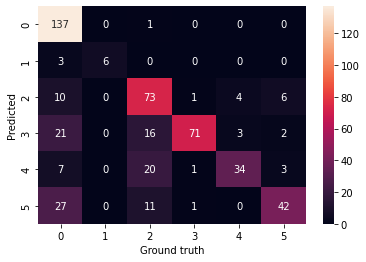

In [66]:
sns.heatmap(confusion_matrix(y_true_cnn_rand, y_pred_cnn_rand), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [67]:
for text, pred, truth in zip(test[0:10], y_pred_cnn_rand[0:10], y_true_cnn_rand[0:10]):
    print(f"{text[1]['text']} -- {idx2label[pred]} -- {idx2label[truth]}")

How far is it from Denver to Aspen ? -- NUM -- NUM
What county is Modesto , California in ? -- LOC -- LOC
Who was Galileo ? -- DESC -- HUM
What is an atom ? -- DESC -- DESC
When did Hawaii become a state ? -- ENTY -- NUM
How tall is the Sears Building ? -- NUM -- NUM
George Bush purchased a small interest in which baseball team ? -- HUM -- HUM
What is Australia 's national flower ? -- DESC -- ENTY
Why does the moon turn orange ? -- DESC -- DESC
What is autism ? -- DESC -- DESC


## Evaluate for cnn_static

In [68]:
y_pred_cnn_static, y_true_cnn_static = eval_testset(cnn_static.to("cpu"))

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
print(classification_report(y_true_cnn_static, y_pred_cnn_static, target_names = label2idx.keys()))

              precision    recall  f1-score   support

        DESC       0.92      0.97      0.95       138
        ABBR       1.00      0.78      0.88         9
        ENTY       0.91      0.79      0.85        94
         NUM       0.96      0.96      0.96       113
         HUM       0.90      0.92      0.91        65
         LOC       0.90      0.98      0.93        81

    accuracy                           0.92       500
   macro avg       0.93      0.90      0.91       500
weighted avg       0.92      0.92      0.92       500



In [71]:
print(f"Accuracy: {accuracy_score(y_true_cnn_static, y_pred_cnn_static):.6f} | \
        Precision: {precision_score(y_true_cnn_static, y_pred_cnn_static, average = 'macro'):.6f} | \
        Recall: {recall_score(y_true_cnn_static, y_pred_cnn_static, average = 'macro'):.6f} | \
        F1 score: {f1_score(y_true_cnn_static, y_pred_cnn_static, average = 'macro'):.6f}")


Accuracy: 0.924000 |         Precision: 0.932542 |         Recall: 0.898361 |         F1 score: 0.911952


In [72]:
print(confusion_matrix(y_true_cnn_static, y_pred_cnn_static))

[[134   0   3   1   0   0]
 [  2   7   0   0   0   0]
 [  5   0  74   3   6   6]
 [  2   0   1 108   0   2]
 [  2   0   2   0  60   1]
 [  0   0   1   0   1  79]]


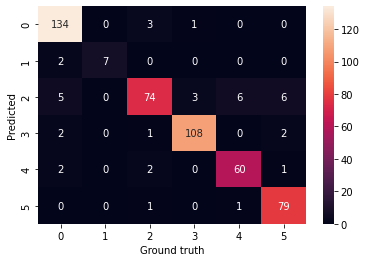

In [73]:
sns.heatmap(confusion_matrix(y_true_cnn_static, y_pred_cnn_static), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [74]:
for text, pred, truth in zip(test[0:10], y_pred_cnn_static[0:10], y_true_cnn_static[0:10]):
    print(f"{text[1]['text']} -- {idx2label[pred]} -- {idx2label[truth]}")

How far is it from Denver to Aspen ? -- NUM -- NUM
What county is Modesto , California in ? -- LOC -- LOC
Who was Galileo ? -- HUM -- HUM
What is an atom ? -- DESC -- DESC
When did Hawaii become a state ? -- NUM -- NUM
How tall is the Sears Building ? -- NUM -- NUM
George Bush purchased a small interest in which baseball team ? -- HUM -- HUM
What is Australia 's national flower ? -- DESC -- ENTY
Why does the moon turn orange ? -- DESC -- DESC
What is autism ? -- DESC -- DESC


## Evaluate for cnn_non_static

In [75]:
y_pred_cnn_non_static, y_true_cnn_non_static = eval_testset(cnn_non_static.to("cpu"))

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
print(classification_report(y_true_cnn_non_static, y_pred_cnn_non_static, target_names = label2idx.keys()))

              precision    recall  f1-score   support

        DESC       0.90      0.97      0.93       138
        ABBR       1.00      0.78      0.88         9
        ENTY       0.92      0.76      0.83        94
         NUM       0.96      0.94      0.95       113
         HUM       0.88      0.91      0.89        65
         LOC       0.87      0.96      0.91        81

    accuracy                           0.91       500
   macro avg       0.92      0.89      0.90       500
weighted avg       0.91      0.91      0.91       500



In [78]:
print(f"Accuracy: {accuracy_score(y_true_cnn_non_static, y_pred_cnn_non_static):.6f} | \
        Precision: {precision_score(y_true_cnn_non_static, y_pred_cnn_non_static, average = 'macro'):.6f} | \
        Recall: {recall_score(y_true_cnn_non_static, y_pred_cnn_non_static, average = 'macro'):.6f} | \
        F1 score: {f1_score(y_true_cnn_non_static, y_pred_cnn_non_static, average = 'macro'):.6f}")

Accuracy: 0.910000 |         Precision: 0.922051 |         Recall: 0.885470 |         F1 score: 0.899350


In [79]:
print(confusion_matrix(y_true_cnn_non_static, y_pred_cnn_non_static))

[[134   0   3   1   0   0]
 [  2   7   0   0   0   0]
 [  6   0  71   3   6   8]
 [  4   0   0 106   1   2]
 [  2   0   2   0  59   2]
 [  1   0   1   0   1  78]]


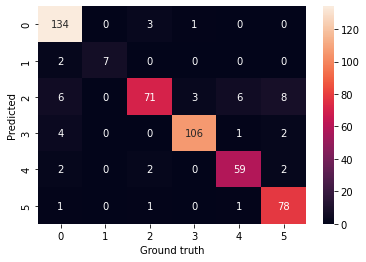

In [80]:
sns.heatmap(confusion_matrix(y_true_cnn_non_static, y_pred_cnn_non_static), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [81]:
for text, pred, truth in zip(test[0:10], y_pred_cnn_non_static[0:10], y_true_cnn_non_static[0:10]):
    print(f"{text[1]['text']} -- {idx2label[pred]} -- {idx2label[truth]}")

How far is it from Denver to Aspen ? -- NUM -- NUM
What county is Modesto , California in ? -- LOC -- LOC
Who was Galileo ? -- HUM -- HUM
What is an atom ? -- DESC -- DESC
When did Hawaii become a state ? -- NUM -- NUM
How tall is the Sears Building ? -- NUM -- NUM
George Bush purchased a small interest in which baseball team ? -- HUM -- HUM
What is Australia 's national flower ? -- DESC -- ENTY
Why does the moon turn orange ? -- DESC -- DESC
What is autism ? -- DESC -- DESC
